## **Instal dan Import Library**

In [1]:
# Instalasi pustaka yang dibutuhkan
!pip install Sastrawi

# Pustaka untuk manipulasi data dan visualisasi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Pemrosesan teks
import re
import string
import requests
import pickle
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import download as nltk_unduh
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Mengunduh dependensi NLTK
nltk_unduh('punkt')
nltk_unduh('punkt_tab')
nltk_unduh('stopwords')

# Pustaka untuk pembelajaran mesin
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix

# Pustaka untuk pembelajaran mendalam
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Flatten, GRU, SpatialDropout1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, Callback, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Menonaktifkan peringatan sistem
import warnings
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.7 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## **Memuat Dataset Ulasan Aplikasi Alfagift**

In [ ]:
# Memuat dataset ualasan dari file yang sudah di simpan di github
df = pd.read_csv('https://raw.githubusercontent.com/riffabella/Submission-Analisis-Sentimen-Aplikasi-Alfagift/refs/heads/main/Dataset/alfagift_reviews.csv')

# Menampilkan beberapa baris awal dari dataset
print("Contoh data ulasan")
df.head()

Contoh data ulasan


,content,score
0,mantap semakin mudah berbelanja,5
1,tiba tiba akun saya sudah ditutup aneh gabisa ...,3
2,"sebenernya aplikasi ini memudahkan hidup, cuma...",3
3,"udah 2 hari error kagak bisa di pakai, setiap ...",1
4,ok bagus,5


## **Exploratory Data Analysis (EDA)**

In [ ]:
# Menampilkan informasi dasar dari dataset
df.info()

# Mengecek apakah ada nilai kosong di setiap kolom
print("Nilai yang hilang:")
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  20000 non-null  object
 1   score    20000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB
Nilai yang hilang:
content    0
score      0
dtype: int64


## **Visualisasi Distribusi Rating Ulasan**

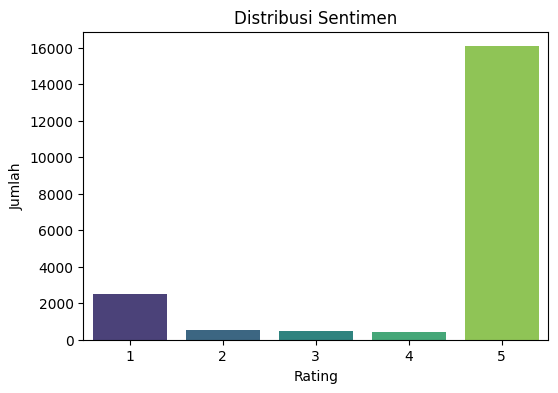

score
5    16072
1     2512
2      526
3      474
4      416
Name: count, dtype: int64


In [ ]:
# Visualisasi distribusi rating pengguna terhadap aplikasi Grab
plt.figure(figsize=(6, 4))
sns.countplot(x=df['score'], palette='viridis')
plt.title("Distribusi Sentimen")
plt.xlabel("Rating")
plt.ylabel("Jumlah")
plt.show()

# Menampilkan jumlah ulasan berdasarkan masing-masing skor
print(df['score'].value_counts())

## **Teks Preprocessing**

**Fungsi Pembersihan Teks Ulasan**

In [ ]:
# Fungsi untuk membersihkan teks ulasan aplikasi
def proses_teks(teks):
    teks = re.sub(r'@[A-Za-z0-9_]+', '', teks)       # Menghapus mention (@username)
    teks = re.sub(r'#[A-Za-z0-9_]+', '', teks)       # Menghapus hashtag (#hashtag)
    teks = re.sub(r'[²]', ' ', teks)                 # Menghapus karakter khusus tertentu
    teks = re.sub(r'\d+', ' ', teks)                 # Menghapus angka
    teks = re.sub(r'[^\w\s]', ' ', teks)             # Menghapus tanda baca
    teks = teks.strip()                              # Menghapus spasi ekstra
    teks = teks.lower()                              # Konversi ke huruf kecil
    return teks

**Fungsi Tokenisasi Teks**

In [ ]:
# Fungsi untuk memecah teks menjadi kata-kata (token)
def tokenisasi_teks(teks):
    teks = word_tokenize(teks)  # Mengubah teks menjadi list token
    return teks

**Fungsi Penghapuasan Stopwords**

In [ ]:
# Fungsi untuk menghapus stopwords dari list token
def filter_stopwords(teks):
    # Memuat stopwords Bahasa Indonesia dan Inggris
    daftar_stopwords = set(stopwords.words('indonesian'))
    daftar_stopwords_english = set(stopwords.words('english'))

    # Menggabungkan stopwords Bahasa Indonesia dan Inggris
    daftar_stopwords.update(daftar_stopwords_english)

    # Menambahkan stopwords tambahan (umum dalam bahasa informal)
    daftar_stopwords.update([
        'iya', 'yaa', 'gak', 'nya', 'na', 'sih', 'ku',
        'di', 'ga', 'ya', 'gaa', 'loh', 'kah', 'woi', 'woii', 'woy'
    ])

    # Memfilter token yang bukan stopwords
    hasil_filter = [kata for kata in teks if kata not in daftar_stopwords]

    return hasil_filter

**Pemrosesan Kata Slang**

In [ ]:
import re

slangwords = {
    "gak": "tidak",
    "ga": "tidak",
    "gabisa": "tidak bisa",
    "gajelas": "tidak jelas",
    "gitu": "seperti itu",
    "gimana": "bagaimana",
    "gitu aja": "hanya begitu",
    "bgt": "banget",
    "bet": "banget",
    "nyh": "ini",
    "udh": "sudah",
    "udah": "sudah",
    "kagak": "tidak",
    "nggak": "tidak",
    "ane": "saya",
    "kesel": "marah",
    "trauma": "kecewa berat",
    "sumpah ya": "",
    "capek": "lelah",
    "rusakkk": "rusak",
    "kecewaaa": "kecewa",
    "lelet": "lambat",
    "bet dah": "banget",
    "taro": "letak",
    "kapok": "jera",
    "bener²": "benar-benar",
    "ngirimin": "mengirimkan",
    "nongkrong": "duduk santai",
    "sampe": "sampai",
    "cekout": "checkout",
    "bnget": "banget",
    "dikirim-kirim": "belum dikirim",
    "diangkat-angkat": "tidak diangkat",
    "pake": "pakai",
    "apk": "aplikasi",
    "distop": "dihentikan"
}

def fix_slangwords(text):
    text = text.lower()

    # Ganti frasa slang (yang terdiri dari >1 kata) dulu
    for slang, formal in slangwords.items():
        if " " in slang:
            text = re.sub(r'\b' + re.escape(slang) + r'\b', formal, text)

    # Ganti kata slang satu per satu
    words = text.split()
    fixed_words = []

    for word in words:
        if word in slangwords:
            fixed_words.append(slangwords[word])
        else:
            fixed_words.append(word)

    return ' '.join(fixed_words)

**Pipeline Pembersihan dan Normalisasi Teks**

In [ ]:
# Menggabungkan daftar token menjadi satu kalimat
def gabungkan_ke_kalimat(tokens):
    return ' '.join(tokens)

# Bersihkan teks dan simpan hasilnya di kolom 'clean_text'
df['clean_text'] = df['content'].apply(proses_teks) # Changed 'bersihkan_teks' to 'proses_teks'

# Ganti kata slang dengan kata standar dan simpan di 'text_slangwords'
df['text_slangwords'] = df['clean_text'].apply(fix_slangwords)

# Tokenisasi teks (pisah menjadi kata-kata) dan simpan di 'text_tokenizing'
df['text_tokenizing'] = df['text_slangwords'].apply(tokenisasi_teks)

# Hapus stopwords (kata umum) dan simpan hasilnya di 'text_stopword'
df['text_stopword'] = df['text_tokenizing'].apply(filter_stopwords)

# Gabungkan token menjadi kalimat dan simpan di 'clean_content'
df['clean_content'] = df['text_stopword'].apply(gabungkan_ke_kalimat)

**Memuat Leksikon Sentimen (Posistive & Negative WOrd List**

In [ ]:
# Fungsi untuk mengambil data leksikon secara aman
def ambil_lexikon(url):
    response = requests.get(url)
    if response.status_code == 200:
        kata_kata = set(kata.strip() for kata in response.text.split("\n") if kata.strip())
        return kata_kata
    else:
        print(f"Gagal mengambil data dari {url}, kode status: {response.status_code}")
        return set()

# Unduh dan muat leksikon kata positif
url_positif = "https://raw.githubusercontent.com/masdevid/ID-OpinionWords/master/positive.txt"
lexikon_positif = ambil_lexikon(url_positif)

# Unduh dan muat leksikon kata negatif
url_negatif = "https://raw.githubusercontent.com/masdevid/ID-OpinionWords/master/negative.txt"
lexikon_negatif = ambil_lexikon(url_negatif)

# Tampilkan statistik leksikon
print(f"Jumlah kata positif: {len(lexikon_positif)}")
print(f"Jumlah kata negatif: {len(lexikon_negatif)}")

Jumlah kata positif: 1182
Jumlah kata negatif: 2402


**Menentukan Sentimen Ulasan Berdasarkan Leksikon**

In [ ]:
# Menentukan label sentimen berdasarkan leksikon
def tentukan_sentimen(teks):
    skor = 0
    for kata in teks:
        if kata in lexikon_positif:
            skor += 1
        if kata in lexikon_negatif:
            skor -= 1

    if skor > 0:
        sentimen = 'positif'
    elif skor < 0:
        sentimen = 'negatif'
    else:
        sentimen = 'netral'

    return skor, sentimen

# Terapkan pelabelan sentimen ke kolom 'text_stopword'
hasil_sentimen = df['text_stopword'].apply(tentukan_sentimen)
hasil_sentimen = list(zip(*hasil_sentimen))
df['sentimen_skor'] = hasil_sentimen[0]
df['sentimen'] = hasil_sentimen[1]

# Tampilkan jumlah masing-masing kategori sentimen
print(df['sentimen'].value_counts())

sentimen
positif    10274
netral      7783
negatif     1943
Name: count, dtype: int64


Visualisasi Distribusi Sentimen Ulasan Alfagift

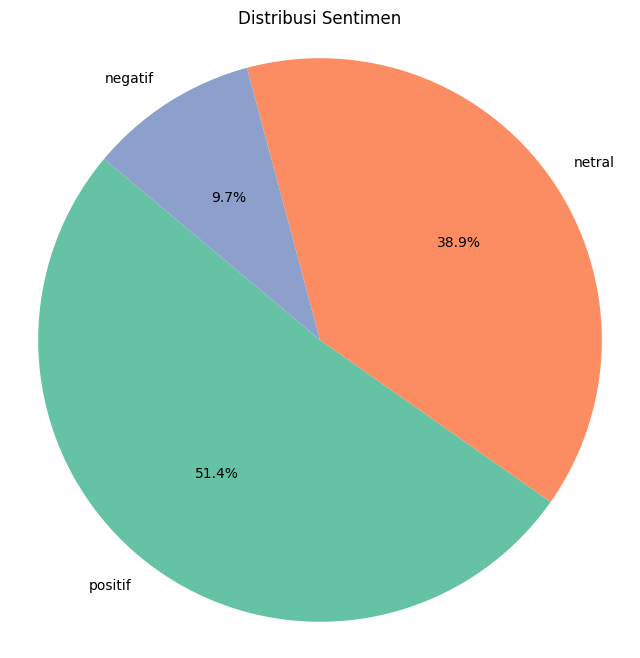

In [ ]:
# Hitung jumlah setiap kategori sentimen
jumlah_sentimen = df['sentimen'].value_counts()

# Tampilkan diagram pie untuk distribusi sentimen
plt.figure(figsize=(8, 8))
plt.pie(jumlah_sentimen,
        labels=jumlah_sentimen.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=sns.color_palette("Set2"))
plt.title('Distribusi Sentimen')
plt.axis('equal')  # Supaya pie-nya bulat sempurna
plt.show()

## **Preprocessing Data Model**

**Menyiapkan Fitur dan Label untuk Model Machine Learning**

In [ ]:
# Ambil kolom 'clean_content' sebagai fitur (X) dan 'sentimen' sebagai label (y)
fitur = df['clean_content']
label = df['sentimen'].map({'positif': 2, 'netral': 1, 'negatif': 0})  # Label numerik

## **Feature Engineering**

**Vektorisasi Teks Menggunakan TF-IDF**

In [ ]:
# Transformasi teks ke vektor angka menggunakan TF-IDF
tfidf = TfidfVectorizer(max_features=10000)
fitur_tfidf = tfidf.fit_transform(fitur)

# Menampilkan dimensi data hasil vektorisasi
print("Ringkasan Fitur dan Data:")
print(f"Dimensi fitur TF-IDF: {fitur_tfidf.shape}")

Ringkasan Fitur dan Data:
Dimensi fitur TF-IDF: (20000, 10000)


**Praprocessing Teks untuk Modek LSTM**

In [ ]:
# Menginisialisasi tokenizer dan membatasi jumlah kata unik sebanyak 10.000
tokenizer = Tokenizer(num_words=10000)

# Menyesuaikan tokenizer dengan teks yang telah dibersihkan
tokenizer.fit_on_texts(fitur)

# Mengubah teks menjadi urutan angka berdasarkan kamus tokenizer
fitur_sekuensial = tokenizer.texts_to_sequences(fitur)

# Menyamakan panjang urutan dengan padding (maksimal 100 kata)
fitur_padat = pad_sequences(fitur_sekuensial, maxlen=100)

**Menampilkan Statistik Data untuk Pelatihan Model**

In [ ]:
# Menghitung jumlah kelas sentimen
jumlah_kelas = len(np.unique(label))
print(f"Jumlah kelas: {jumlah_kelas}")

# Menampilkan dimensi dari fitur hasil padding
print(f"Dimensi urutan fitur: {fitur_padat.shape}")

# Menampilkan ukuran kosa kata dari tokenizer
kosa_kata_index = tokenizer.word_index
print(f"\nUkuran kosa kata: {len(kosa_kata_index)} kata")

Jumlah kelas: 3
Dimensi urutan fitur: (20000, 100)

Ukuran kosa kata: 10171 kata


## **Model Training dan Evaluation**

**Deep Learning Model (LSTM)**

Membangun dan Melatih Model LSTM untuk Klasifikasi Sentimen

In [ ]:
# Membagi data menjadi: pelatihan (70%), pengujian (20%), dan validasi (10%)
fitur_latih_lstm, fitur_uji_lstm, label_latih_lstm, label_uji_lstm = train_test_split(
    fitur_padat, label, test_size=0.2, random_state=42
)

# Mengambil 10% dari 80% data latih sebagai data validasi (0.1 / 0.8 = 0.125)
fitur_latih_lstm, fitur_validasi_lstm, label_latih_lstm, label_validasi_lstm = train_test_split(
    fitur_latih_lstm, label_latih_lstm, test_size=0.125, random_state=42
)

# Menampilkan jumlah sampel di setiap subset
print("Total Sampel:")
print(f"Set pelatihan: {fitur_latih_lstm.shape[0]} sampel")
print(f"Set validasi : {fitur_validasi_lstm.shape[0]} sampel")
print(f"Set pengujian: {fitur_uji_lstm.shape[0]} sampel")

Total Sampel:
Set pelatihan: 14000 sampel
Set validasi : 2000 sampel
Set pengujian: 4000 sampel


Membangun dan Melatih Model LSTM untuk Klasifikasi Sentimen

In [ ]:
# Membuat model LSTM untuk klasifikasi sentimen
model_lstm = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=100),       # Representasi kata dalam vektor
    SpatialDropout1D(0.4),                                               # Dropout untuk regularisasi
    LSTM(128, dropout=0.3, recurrent_dropout=0.3),                       # LSTM untuk memahami urutan kata
    Dense(3, activation='softmax')                                       # Output 3 kelas sentimen
])

# Menyusun model dengan loss dan optimizer
model_lstm.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

# Callback untuk kontrol pelatihan
callback_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)
callback_lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2
)

# Daftar callback
callbacks = [callback_early_stopping, callback_lr_reduction]

# Menjalankan pelatihan model
riwayat_latihan = model_lstm.fit(
    fitur_latih_lstm, label_latih_lstm,
    validation_data=(fitur_validasi_lstm, label_validasi_lstm),
    epochs=15,
    batch_size=64,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 98s 372ms/step - accuracy: 0.6666 - loss: 0.7227 - val_accuracy: 0.8640 - val_loss: 0.3284 - learning_rate: 0.0010
Epoch 2/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 140s 396ms/step - accuracy: 0.9231 - loss: 0.2105 - val_accuracy: 0.9475 - val_loss: 0.1476 - learning_rate: 0.0010
Epoch 3/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 126s 325ms/step - accuracy: 0.9692 - loss: 0.0986 - val_accuracy: 0.9570 - val_loss: 0.1313 - learning_rate: 0.0010
Epoch 4/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 70s 318ms/step - accuracy: 0.9824 - loss: 0.0551 - val_accuracy: 0.9555 - val_loss: 0.1286 - learning_rate: 0.0010
Epoch 5/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 83s 326ms/step - accuracy: 0.9888 - loss: 0.0398 - val_accuracy: 0.9530 - val_loss: 0.1453 - learning_rate: 0.0010
Epoch 6/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 71s 325ms/step - accuracy: 0.9908 - loss: 0.0314 - val_accuracy: 0.9675 - val_loss: 0.1167 - learning_rate: 0.0010
Epoch 7/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 83s 331ms/step - accuracy: 0

Evaluasi dan Visualisasi Performa Model LSTM

125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.9679 - loss: 0.1201

Evaluasi Model LSTM
Akurasi pelatihan per epoch terakhir: 0.9959
Akurasi pengujian akhir: 0.9707
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step

Laporan Klasifikasi:
              precision    recall  f1-score   support

     negatif       0.93      0.94      0.93       369
      netral       0.97      0.96      0.96      1540
     positif       0.98      0.98      0.98      2091

    accuracy                           0.97      4000
   macro avg       0.96      0.96      0.96      4000
weighted avg       0.97      0.97      0.97      4000



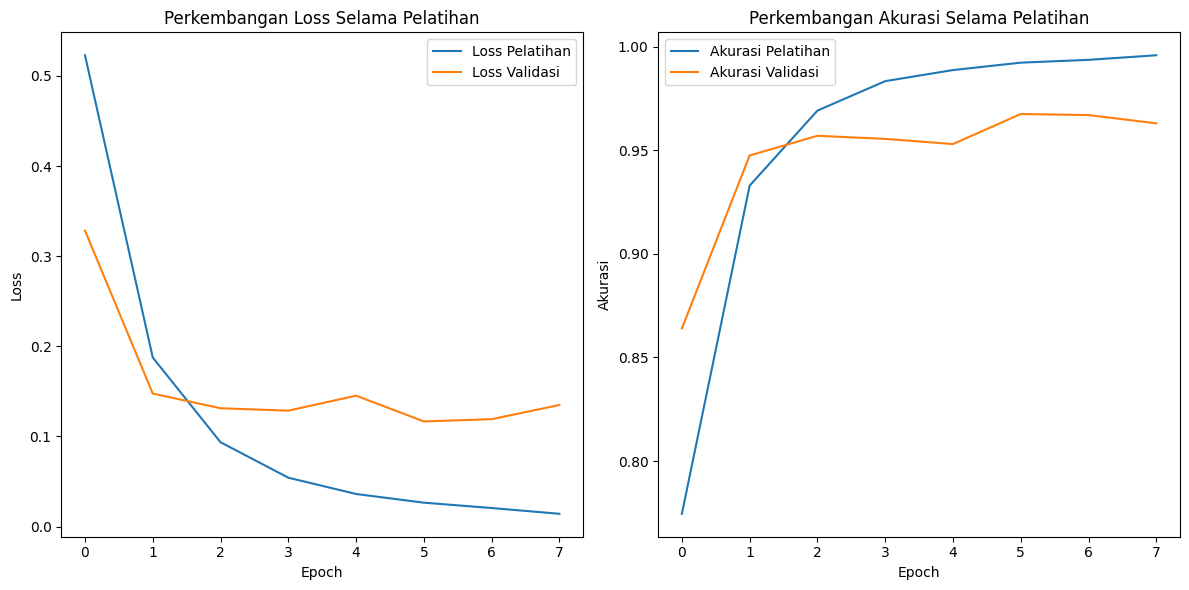

In [ ]:
# Mengambil nilai akurasi pelatihan terakhir
akurasi_latih = riwayat_latihan.history['accuracy']

# Evaluasi terhadap data pengujian
kerugian_uji, akurasi_lstm = model_lstm.evaluate(fitur_uji_lstm, label_uji_lstm)

# Menampilkan hasil evaluasi
print("\nEvaluasi Model LSTM")
print(f"Akurasi pelatihan per epoch terakhir: {akurasi_latih[-1]:.4f}")
print(f"Akurasi pengujian akhir: {akurasi_lstm:.4f}")

# Prediksi terhadap data uji
y_prediksi = np.argmax(model_lstm.predict(fitur_uji_lstm), axis=1)

# Menampilkan laporan klasifikasi berdasarkan label sebenarnya
print("\nLaporan Klasifikasi:")
print(classification_report(label_uji_lstm, y_prediksi, target_names=['negatif', 'netral', 'positif']))

# Visualisasi loss dan akurasi selama pelatihan
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(riwayat_latihan.history['loss'], label='Loss Pelatihan')
plt.plot(riwayat_latihan.history['val_loss'], label='Loss Validasi')
plt.title('Perkembangan Loss Selama Pelatihan')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot akurasi
plt.subplot(1, 2, 2)
plt.plot(riwayat_latihan.history['accuracy'], label='Akurasi Pelatihan')
plt.plot(riwayat_latihan.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Perkembangan Akurasi Selama Pelatihan')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

plt.tight_layout()
plt.show()

Visualisasi Confusion Matrix Model LSTM

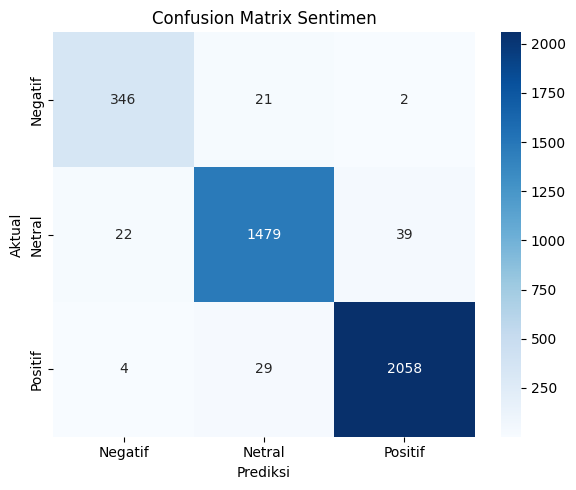

In [ ]:
# Membuat confusion matrix
matriks_konfusi = confusion_matrix(label_uji_lstm, y_prediksi)

# Menentukan label kelas
label_kategori = ['Negatif', 'Netral', 'Positif']

# Menampilkan confusion matrix dengan heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(matriks_konfusi, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_kategori, yticklabels=label_kategori)
plt.title('Confusion Matrix Sentimen')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.tight_layout()
plt.show()

Menghitung Akurasi, Precision, Recall, dan F1-score dari Confusion Matrix

In [ ]:
# Ambil nilai dari confusion matrix
TN, FP, FN, TP = None, None, None, None  # placeholder untuk binary, kita hitung secara multi-kelas

# Mengambil nilai matrix
cm = confusion_matrix(label_uji_lstm, y_prediksi)
print("Confusion Matrix:")
print(cm)

# Hitung metrik per kelas
for i, kelas in enumerate(['Negatif', 'Netral', 'Positif']):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0

    print(f"\nKelas: {kelas}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-score:  {f1:.4f}")

# Hitung akurasi keseluruhan
akurasi_total = np.trace(cm) / np.sum(cm)
print(f"\nAkurasi Keseluruhan: {akurasi_total:.4f}")

Confusion Matrix:
[[ 346   21    2]
 [  22 1479   39]
 [   4   29 2058]]

Kelas: Negatif
  Precision: 0.9301
  Recall:    0.9377
  F1-score:  0.9339

Kelas: Netral
  Precision: 0.9673
  Recall:    0.9604
  F1-score:  0.9638

Kelas: Positif
  Precision: 0.9805
  Recall:    0.9842
  F1-score:  0.9823

Akurasi Keseluruhan: 0.9708


### **Traditional Machine Learning Models**

#### **SVM + TF-IDF (80/20)**

**Membagi Data Pelatihan dan Pengujian**

In [ ]:
# Membagi Data menjadi Set Pelatihan dan Pengujian
X_latih_svm, X_uji_svm, y_latih_svm, y_uji_svm = train_test_split(fitur_tfidf, label, test_size=0.2, random_state=42)

print("Total Sampel:")
print(f"Set pelatihan: {X_latih_svm.shape[0]} sampel")
print(f"Set pengujian: {X_uji_svm.shape[0]} sampel")

Total Sampel:
Set pelatihan: 16000 sampel
Set pengujian: 4000 sampel


**Pelatihan dan Prediksi Model SVM**

In [ ]:
# Inisialisasi Model SVM dengan Kernel Linear
model_svm = SVC(kernel='linear', probability=True)

# Latih Model
model_svm.fit(X_latih_svm, y_latih_svm)

# Lakukan Prediksi
y_pred_svm = model_svm.predict(X_uji_svm)

**Evaluasi Model SVM Berbasis TF-IDF**


Evaluasi Model SVM + TF-IDF

Akurasi Latih: 0.9813
Akurasi Uji: 0.9517

Laporan Klasifikasi:
              precision    recall  f1-score   support

     negatif       0.93      0.79      0.85       369
      netral       0.91      0.97      0.94      1540
     positif       0.99      0.96      0.98      2091

    accuracy                           0.95      4000
   macro avg       0.94      0.91      0.92      4000
weighted avg       0.95      0.95      0.95      4000



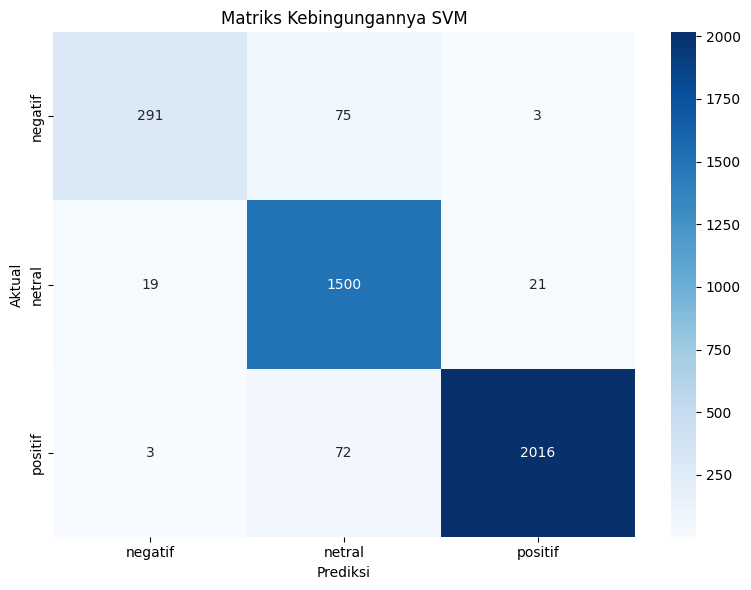

In [ ]:
# Evaluasi Model
akurasi_latih_svm = accuracy_score(y_latih_svm, model_svm.predict(X_latih_svm))
akurasi_svm = accuracy_score(y_uji_svm, y_pred_svm)

print("\nEvaluasi Model SVM + TF-IDF")
print(f'\nAkurasi Latih: {akurasi_latih_svm:.4f}')
print(f'Akurasi Uji: {akurasi_svm:.4f}')

print("\nLaporan Klasifikasi:")
print(classification_report(y_uji_svm, y_pred_svm, target_names=['negatif', 'netral', 'positif']))

# Plot Matriks Kebingungannya
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_uji_svm, y_pred_svm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negatif', 'netral', 'positif'],
            yticklabels=['negatif', 'netral', 'positif'])
plt.title('Matriks Kebingungannya SVM')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.tight_layout()
plt.show()

#### **Random Forest + TF-IDF (70/30)**

**Membagi Data Pelatihan dan Pengujian**

In [ ]:
# Bagi Data menjadi Set Latih dan Set Uji (70% Latih, 30% Uji)
X_latih_rf, X_uji_rf, y_latih_rf, y_uji_rf = train_test_split(fitur_tfidf, label, test_size=0.3, random_state=42)

print("Jumlah Sampel: ")
print(f"Set Latih: {X_latih_rf.shape[0]} sampel")
print(f"Set Uji: {X_uji_rf.shape[0]} sampel")

Jumlah Sampel: 
Set Latih: 14000 sampel
Set Uji: 6000 sampel


**Inisialisasi dan Pelatihan Model Random Forest untuk Klasifikasi Sentimen**

In [ ]:
# Inisialisasi Model Random Forest dengan Penyesuaian Hyperparameter
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

# Latih Model
rf_model.fit(X_latih_rf, y_latih_rf)

# Lakukan Prediksi
y_pred_rf = rf_model.predict(X_uji_rf)

**Evaluasi Model Random Forest dengan Representasi TF-IDF**


Evaluasi Model Random Forest dengan TF-IDF
Akurasi Latih: 0.9201
Akurasi Uji: 0.8878

Laporan Klasifikasi:
              precision    recall  f1-score   support

     negatif       0.91      0.67      0.77       556
      netral       0.88      0.84      0.86      2295
     positif       0.89      0.96      0.92      3149

    accuracy                           0.89      6000
   macro avg       0.89      0.82      0.85      6000
weighted avg       0.89      0.89      0.89      6000



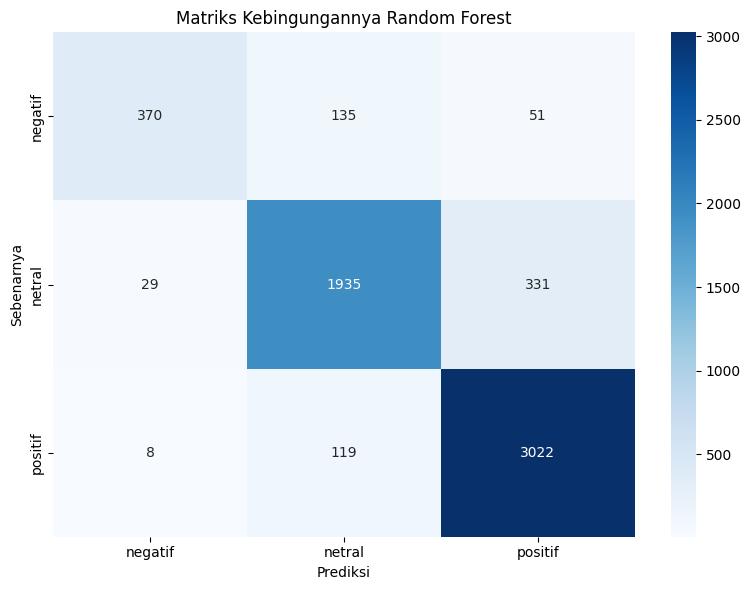

In [ ]:
# Evaluasi Model
akurat_latih = accuracy_score(y_latih_rf, rf_model.predict(X_latih_rf))
akurat_uji_rf = accuracy_score(y_uji_rf, y_pred_rf)

print("\nEvaluasi Model Random Forest dengan TF-IDF")
print(f"Akurasi Latih: {akurat_latih:.4f}")
print(f"Akurasi Uji: {akurat_uji_rf:.4f}")

print("\nLaporan Klasifikasi:")
print(classification_report(y_uji_rf, y_pred_rf, target_names=['negatif', 'netral', 'positif']))

# Plot Matriks Kebingungannya
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_uji_rf, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negatif', 'netral', 'positif'],
            yticklabels=['negatif', 'netral', 'positif'])
plt.title('Matriks Kebingungannya Random Forest')
plt.xlabel('Prediksi')
plt.ylabel('Sebenarnya')
plt.tight_layout()
plt.show()

### **Perbandingan Performa Model**

In [ ]:
# Membuat tabel ringkasan performa model
ringkasan = {
    'Model': ['LSTM + Embedding (80/20)', 'SVM + TF-IDF (80/20)', 'Random Forest + TF-IDF (70/30)'],
    'Akurasi': [akurasi_lstm, akurasi_svm, akurat_uji_rf],  # gunakan nama variabel yang benar
    'Rasio Pembagian Data': ['80/20', '80/20', '70/30'],
    'Jenis Fitur': ['Word Embedding', 'TF-IDF', 'TF-IDF']
}

# Mengonversi ke DataFrame
df_ringkasan = pd.DataFrame(ringkasan)

# Format akurasi menjadi persen
df_ringkasan['Akurasi'] = df_ringkasan['Akurasi'].apply(lambda x: f"{x:.2%}")

# Menampilkan ringkasan
print("Ringkasan Hasil Evaluasi Model")
display(df_ringkasan)

Ringkasan Hasil Evaluasi Model


,Model,Akurasi,Rasio Pembagian Data,Jenis Fitur
0,LSTM + Embedding (80/20),97.07%,80/20,Word Embedding
1,SVM + TF-IDF (80/20),95.17%,80/20,TF-IDF
2,Random Forest + TF-IDF (70/30),88.78%,70/30,TF-IDF


### **Save Models for Inference**

In [ ]:
import os
import pickle

# Buat folder 'Models' jika belum ada
model_dir = "Models"
os.makedirs(model_dir, exist_ok=True)

# ✅ Simpan Model LSTM dalam format Keras modern
model_lstm.save(os.path.join(model_dir, "lstm_sentiment_model.keras"))

# ✅ Simpan Model SVM
with open(os.path.join(model_dir, "svm_sentiment_model.pkl"), "wb") as f:
    pickle.dump(model_svm, f)

# ✅ Simpan Model Random Forest
with open(os.path.join(model_dir, "rf_sentiment_model.pkl"), "wb") as f:
    pickle.dump(rf_model, f)

# ✅ Simpan TF-IDF Vectorizer
with open(os.path.join(model_dir, "vectorizer.pkl"), "wb") as f:
    pickle.dump(tfidf, f)

# ✅ Simpan Tokenizer Keras
with open(os.path.join(model_dir, "tokenizer.pkl"), "wb") as f:
    pickle.dump(tokenizer, f)

print("✅ Semua model dan komponen berhasil disimpan di folder 'Models/'")

✅ Semua model dan komponen berhasil disimpan di folder 'Models/'
